In [1]:
import os, sys
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
#matplotlib options
plt.rc('font', family='serif', size=12)
pltops_hist = { "histtype":'step', "linewidth":1.5}
plt.rc('image', cmap='seismic')
plt.rcParams['figure.figsize'] = (10.0, 8.0)

from cycler import cycler
plt.rcParams['axes.prop_cycle'] = cycler(color=['b','g','r','c','m','y','k','indigo','orange','#137e6d'])

def make_profile_bins(df,lowbin,hibin,nbins,xarg,yarg,option='sem'):
    xbins = np.linspace(lowbin,hibin,nbins+1)
    diff = (xbins[1]-xbins[0])*0.00001
    xbins[-1] = xbins[-1]+diff
    result = (df[[xarg,yarg]].groupby(np.digitize(df[xarg],bins=xbins,right=False)))[yarg].agg(['mean',option])
    result = result.reindex(range(1,len(xbins),1))
    xbins[-1] = xbins[-1]-diff
    result["x"] = 0.5*(xbins[:-1]+xbins[1:])
    result["xerr"] = 0.5*(xbins[1]-xbins[0])
    result.rename(columns={'mean': 'y', option: 'yerr'}, inplace=True)
    return result

def make_hists(df,hists,bins,axis,histtype='step',stacked=True):
    n,cbins,patches = axis.hist([df.query(hd['cut'])[hd['var']] for hd in hists],
                                weights=[df.query(hd['cut'])[hd['weight']] for hd in hists],
                                label=["%s: %.1f"%(hd['label'],df.query(hd['cut'])[hd['weight']].sum()) for hd in hists],
                                bins=bins,histtype=histtype,stacked=stacked)
    for i in range(0,len(patches)):
        hd = hists[i]
        for p in patches[i]:
            if 'color' in hd: p.set_color(hd['color'])
            if 'facecolor' in hd: p.set_facecolor(hd['facecolor'])
            if 'edgecolor' in hd: p.set_edgecolor(hd['edgecolor'])
            if 'fill' in hd: p.set_fill(hd['fill'])
            if 'hatch' in hd: p.set_hatch(hd['hatch'])
            if 'linewidth' in hd: p.set_linewidth(hd['linewidth'])

In [3]:
%matplotlib notebook

In [4]:
ev_df_cv = pd.read_hdf("/Users/wketchum/Data/MicroBooNE/FakeData2020/CVSet/mcana_dfs.h5","ev_df")
pot_df_cv = pd.read_hdf("/Users/wketchum/Data/MicroBooNE/FakeData2020/CVSet/mcana_dfs.h5","pot_df")
cv_title = "$\mu$BooNE CV"
cv_leg = "CV"

In [5]:
ev_df_fd = pd.read_hdf("/Users/wketchum/Data/MicroBooNE/FakeData2020/Set1/mcana_dfs.h5","ev_df")
pot_df_fd = pd.read_hdf("/Users/wketchum/Data/MicroBooNE/FakeData2020/Set1/mcana_dfs.h5","pot_df")
fd_title = "Fake Data Set 1"
fd_leg="Set1"

In [6]:
# POT not in CV. Use POT/event number from GENIE v2 for now ...
#total_pot_cv = pot_df_cv["totpot"].sum()
total_pot_cv = len(ev_df_cv)*9.9158e14

total_pot_fd = pot_df_fd["totpot"].sum()

weight_pot_fd = total_pot_fd/total_pot_cv
#weight_pot_fd = 0.8

print("POT, CV=%.2E\nPOT, Fake Data=%.2E\nPOT Weight=%f"%(total_pot_cv,total_pot_fd,weight_pot_fd))

ev_df_cv["weight_pot"] = weight_pot_fd

POT, CV=7.88E+20
POT, Fake Data=5.92E+20
POT Weight=0.750959


In [7]:
#apply fiducial volume

MIN_X = 0.
MAX_X = 254.
MIN_Y = -115.
MAX_Y = 115.
MIN_Z = 0.
MAX_Z = 1036.
fid_vol_query = "start_x>%f and start_x<%f and start_y>%f and start_y<%f and start_z>%f and start_z<%f"%(MIN_X,MAX_X,MIN_Y,MAX_Y,MIN_Z,MAX_Z)

ev_df_cv = ev_df_cv.query(fid_vol_query)
ev_df_fd = ev_df_fd.query(fid_vol_query)

In [8]:
total_evs_cv = ev_df_cv["weight_pot"].sum()
total_evs_fd = len(ev_df_fd)
weight_ev = total_evs_fd/float(total_evs_cv)

print("Events, CV=%d\nEvent, Fake Data=%d\nRatio=%f"%(total_evs_cv,total_evs_fd,weight_ev))

Events, CV=257167
Event, Fake Data=201666
Ratio=0.784182


In [9]:
query_1mu0p = "n_mu==1 and n_p_40MeV==0 and n_chpi==0 and n_pi0==0 and n_e==0 and n_gamma==0"
query_1mu1p = "n_mu==1 and n_p_40MeV==1 and n_chpi==0 and n_pi0==0 and n_e==0 and n_gamma==0"
query_1muNp = "n_mu==1 and n_p_40MeV>0 and n_chpi==0 and n_pi0==0 and n_e==0 and n_gamma==0"
query_1muXp = "n_mu==1 and n_p_40MeV>-1 and n_chpi==0 and n_pi0==0 and n_e==0 and n_gamma==0"

query_1e0p = "n_mu==0 and n_p_40MeV==0 and n_chpi==0 and n_pi0==0 and n_e==1 and n_gamma==0"
query_1e1p = "n_mu==0 and n_p_40MeV==1 and n_chpi==0 and n_pi0==0 and n_e==1 and n_gamma==0"
query_1eNp = "n_mu==0 and n_p_40MeV>0 and n_chpi==0 and n_pi0==0 and n_e==1 and n_gamma==0"
query_1eXp = "n_mu==0 and n_p_40MeV>-1 and n_chpi==0 and n_pi0==0 and n_e==1 and n_gamma==0"

query_ccpi0 = "n_mu==1 and n_pi0>0 and n_e==0"
query_ncpi0 = "n_mu==0 and n_pi0>0 and n_e==0"

query_1g0p = "n_mu==0 and n_p_40MeV==1 and n_chpi==0 and n_pi0==0 and n_e==0 and n_gamma==1"
query_1g1p = "n_mu==0 and n_p_40MeV==1 and n_chpi==0 and n_pi0==0 and n_e==0 and n_gamma==1"
query_1gNp = "n_mu==0 and n_p_40MeV>0 and n_chpi==0 and n_pi0==0 and n_e==0 and n_gamma==1"
query_1gXp = "n_mu==0 and n_p_40MeV>-1 and n_chpi==0 and n_pi0==0 and n_e==0 and n_gamma==1"

In [10]:
query_numu_cc = "pdgcode==14 and n_mu==1"
query_numu_nc = "pdgcode==14 and n_mu==0"
query_nue_cc = "pdgcode==12 and n_e==1"
query_nue_nc = "pdgcode==12 and n_e==0"

query_numu_ccqe = "pdgcode==14 and n_mu==1 and mode==0"
query_numu_ncqe = "pdgcode==14 and n_mu==0 and mode==0"
query_numu_ccmec = "pdgcode==14 and n_mu==1 and mode==10"
query_numu_ncmec = "pdgcode==14 and n_mu==0 and mode==10"
query_numu_ccres = "pdgcode==14 and n_mu==1 and mode!=0 and mode!=10" 
query_numu_ncres = "pdgcode==14 and n_mu==0 and mode!=0 and mode!=10"

query_nue_ccqe = "pdgcode==12 and n_e==1 and mode==0"
query_nue_ncqe = "pdgcode==12 and n_e==0 and mode==0"
query_nue_ccmec = "pdgcode==12 and n_e==1 and mode==10"
query_nue_ncmec = "pdgcode==12 and n_e==0 and mode==10"
query_nue_ccres = "pdgcode==12 and n_e==1 and mode!=0 and mode!=10" 
query_nue_ncres = "pdgcode==12 and n_e==0 and mode!=0 and mode!=10"

<IPython.core.display.Javascript object>


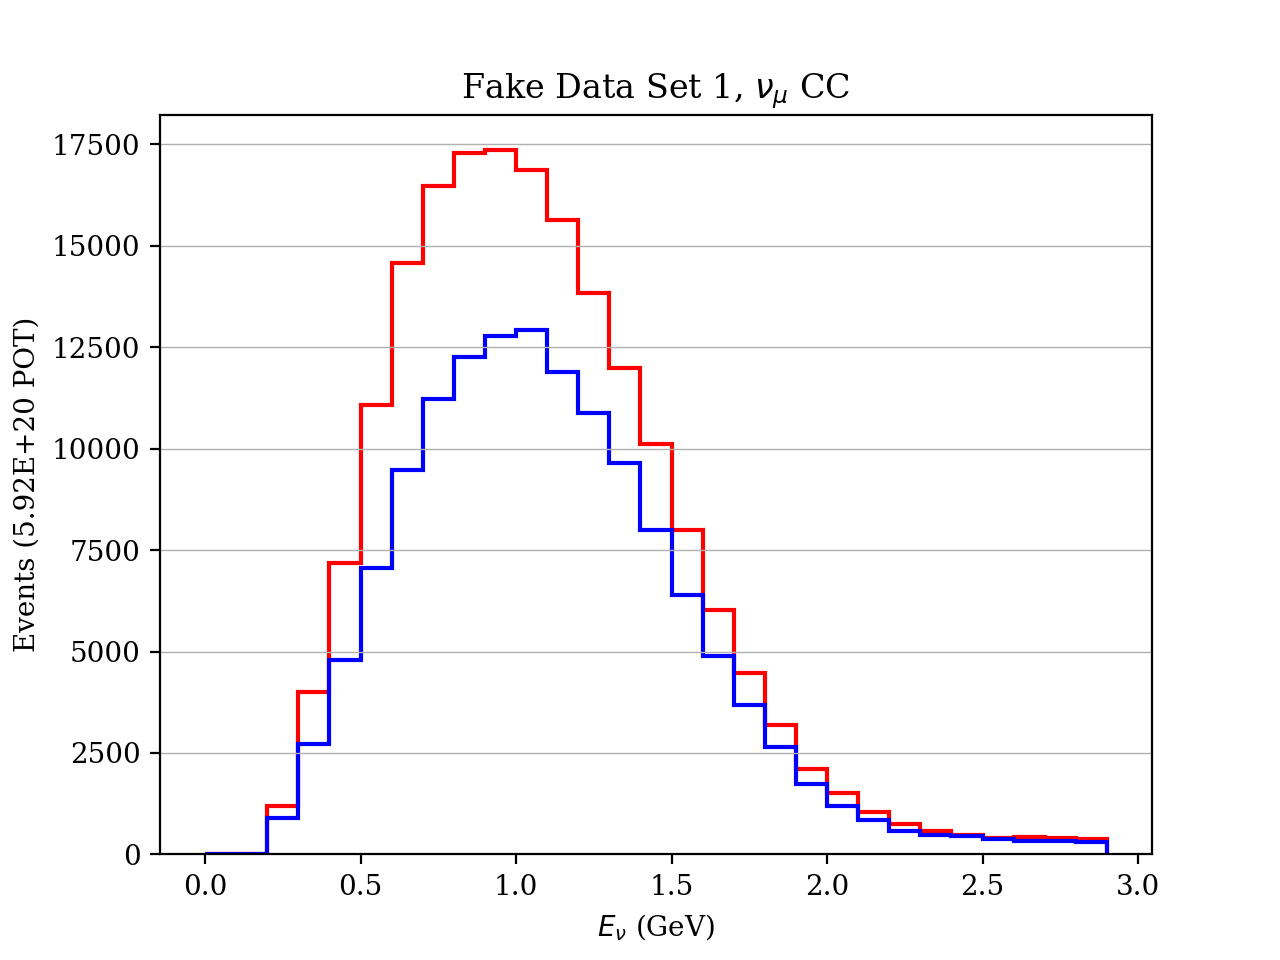

In [11]:
bins = np.arange(0,3.0,0.1)
var="e"
q=query_numu_cc
title="%s, $\\nu_\mu$ CC"%(fd_title)
xlabel="$E_{\\nu}$ (GeV)"
ylabel="Events (%.2E POT)"%(total_pot_fd)

df_cv = ev_df_cv.query(q)
df_fd = ev_df_fd.query(q)

fig,ax = plt.subplots()

plt.grid(axis='y', linewidth=0.5)
plt.hist(df_cv[var], weights=df_cv["weight_pot"], color='red', label=cv_leg, bins=bins,**pltops_hist)
plt.hist(df_fd[var], color='blue', label=fd_leg, bins=bins,**pltops_hist)
#plt.legend(loc=2)
plt.title(title)
plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.show()
#plt.savefig("plots/genie_1mu1p_costheta.pdf")

<IPython.core.display.Javascript object>


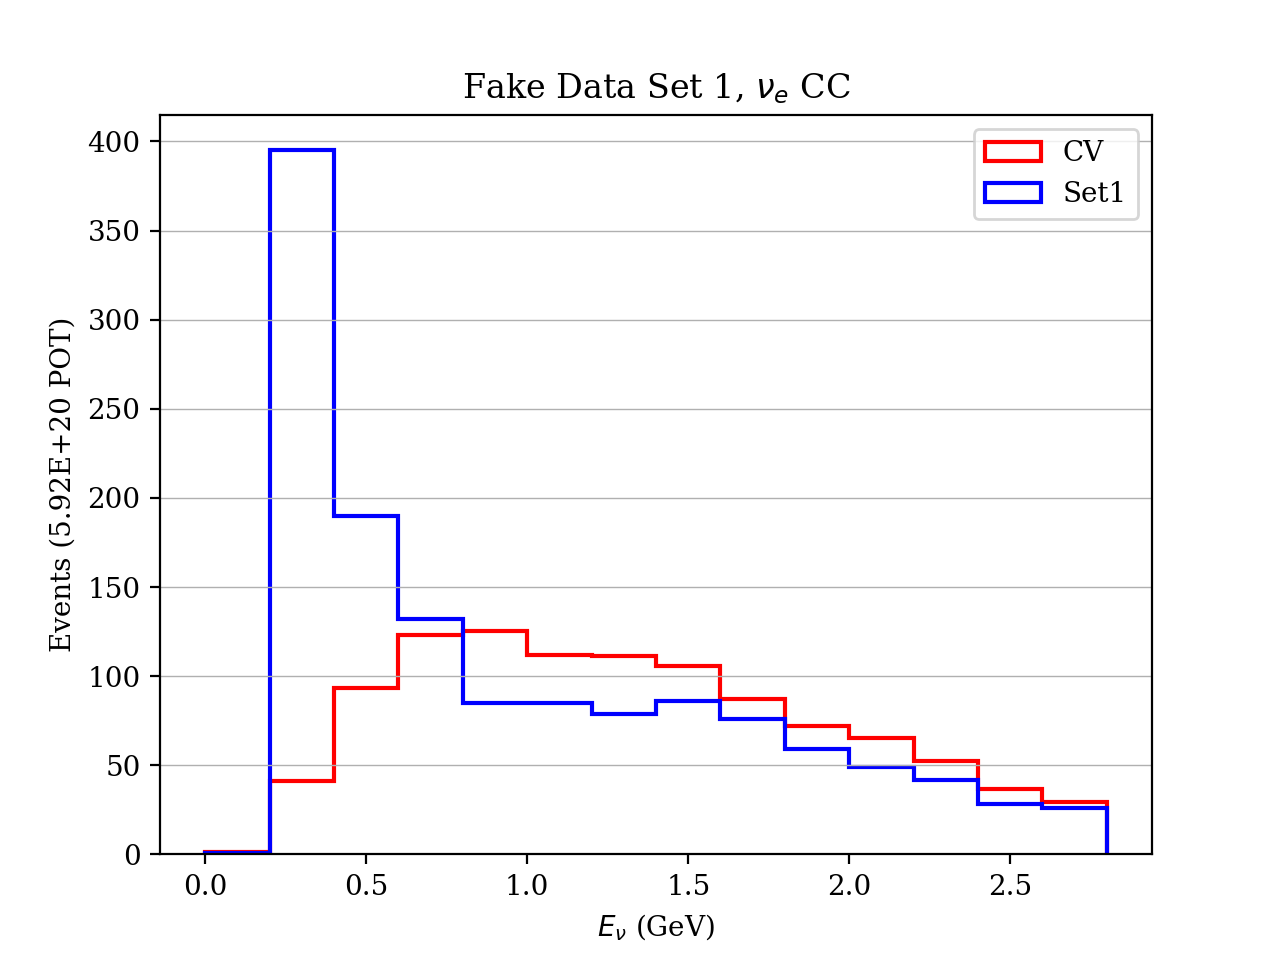

In [12]:
bins = np.arange(0,3.0,0.2)
var="e"
q=query_nue_cc
title="%s, $\\nu_e$ CC"%(fd_title)
xlabel="$E_{\\nu}$ (GeV)"
ylabel="Events (%.2E POT)"%(total_pot_fd)

df_cv = ev_df_cv.query(q)
df_fd = ev_df_fd.query(q)

fig,ax = plt.subplots()

plt.grid(axis='y', linewidth=0.5)
plt.hist(df_cv[var], weights=df_cv["weight_pot"], color='red', label=cv_leg, bins=bins,**pltops_hist)
plt.hist(df_fd[var], color='blue', label=fd_leg, bins=bins,**pltops_hist)
plt.legend()
plt.title(title)
plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.show()
#plt.savefig("plots/genie_1mu1p_costheta.pdf")

<IPython.core.display.Javascript object>


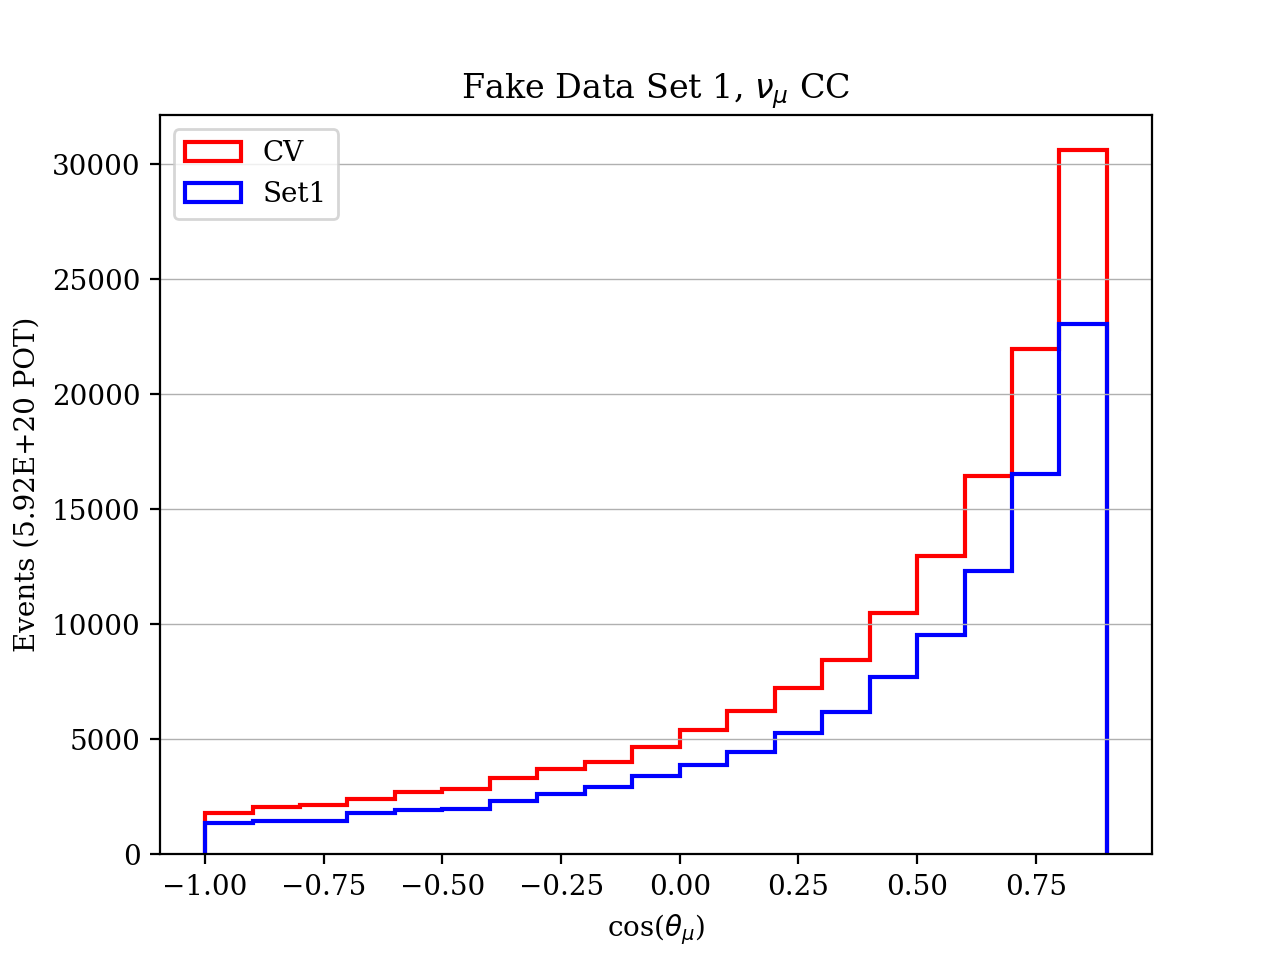

In [13]:
bins = np.arange(-1.0,1.0,0.1)
var="costheta_lep"
q=query_numu_cc
title="%s, $\\nu_\mu$ CC"%(fd_title)
xlabel="cos($\\theta_{\mu}$)"
ylabel="Events (%.2E POT)"%(total_pot_fd)

df_cv = ev_df_cv.query(q)
df_fd = ev_df_fd.query(q)

fig,ax = plt.subplots()

plt.grid(axis='y', linewidth=0.5)
plt.hist(df_cv[var], weights=df_cv["weight_pot"], color='red', label=cv_leg, bins=bins,**pltops_hist)
plt.hist(df_fd[var], color='blue', label=fd_leg, bins=bins,**pltops_hist)
plt.legend(loc=2)
plt.title(title)
plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.show()
#plt.savefig("plots/genie_1mu1p_costheta.pdf")

<IPython.core.display.Javascript object>


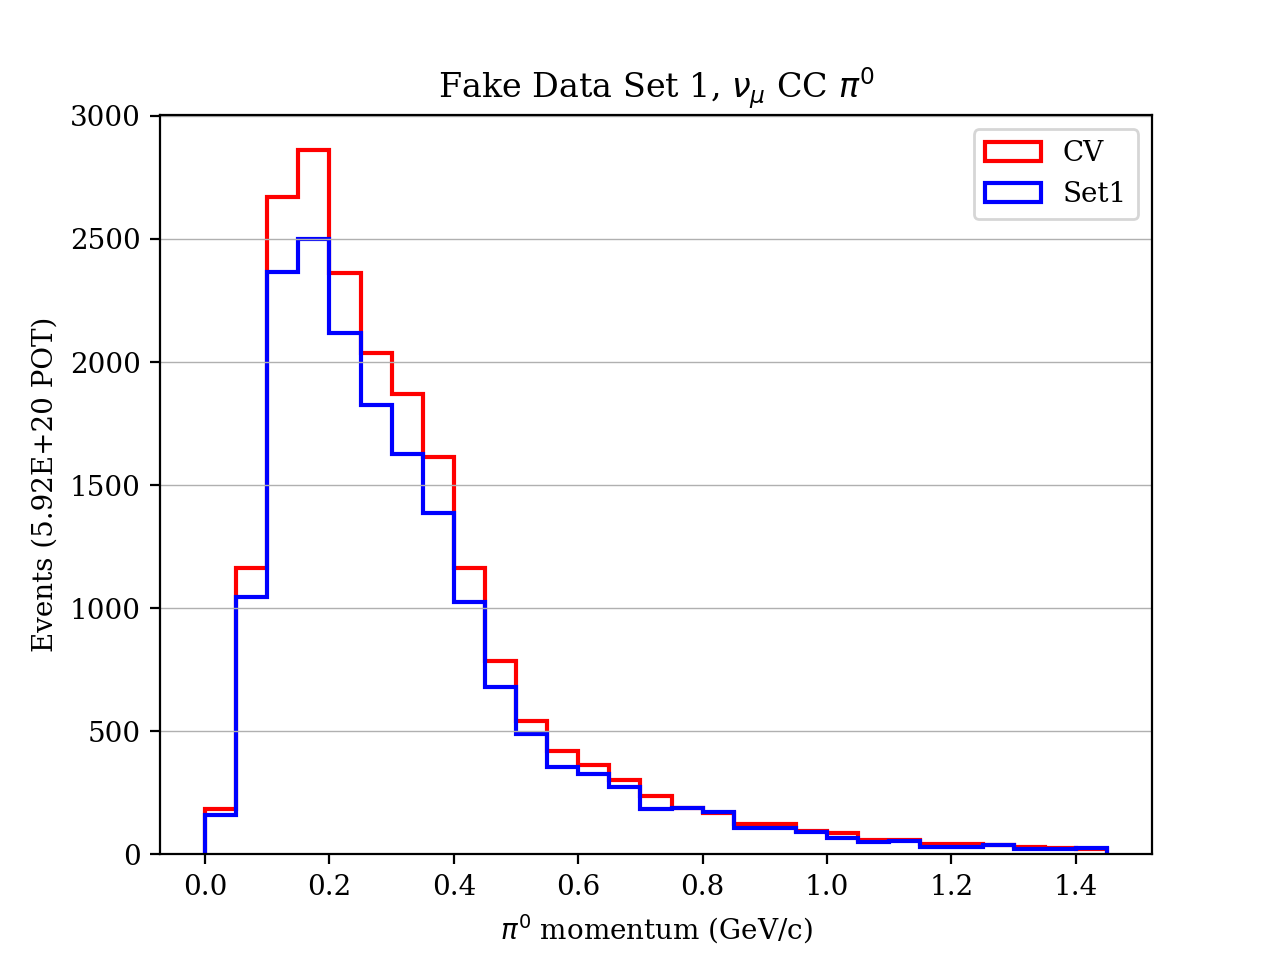

In [14]:
bins = np.arange(0.0,1.5,0.05)
var="p_pi0"
q=query_ccpi0
title="%s, $\\nu_\mu$ CC $\pi^0$"%(fd_title)
xlabel="$\pi^0$ momentum (GeV/c)"
ylabel="Events (%.2E POT)"%(total_pot_fd)

df_cv = ev_df_cv.query(q)
df_fd = ev_df_fd.query(q)

fig,ax = plt.subplots()

plt.grid(axis='y', linewidth=0.5)
plt.hist(df_cv[var], weights=df_cv["weight_pot"], color='red', label=cv_leg, bins=bins,**pltops_hist)
plt.hist(df_fd[var], color='blue', label=fd_leg, bins=bins,**pltops_hist)
plt.legend()
plt.title(title)
plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.show()
#plt.savefig("plots/genie_1mu1p_costheta.pdf")

<IPython.core.display.Javascript object>


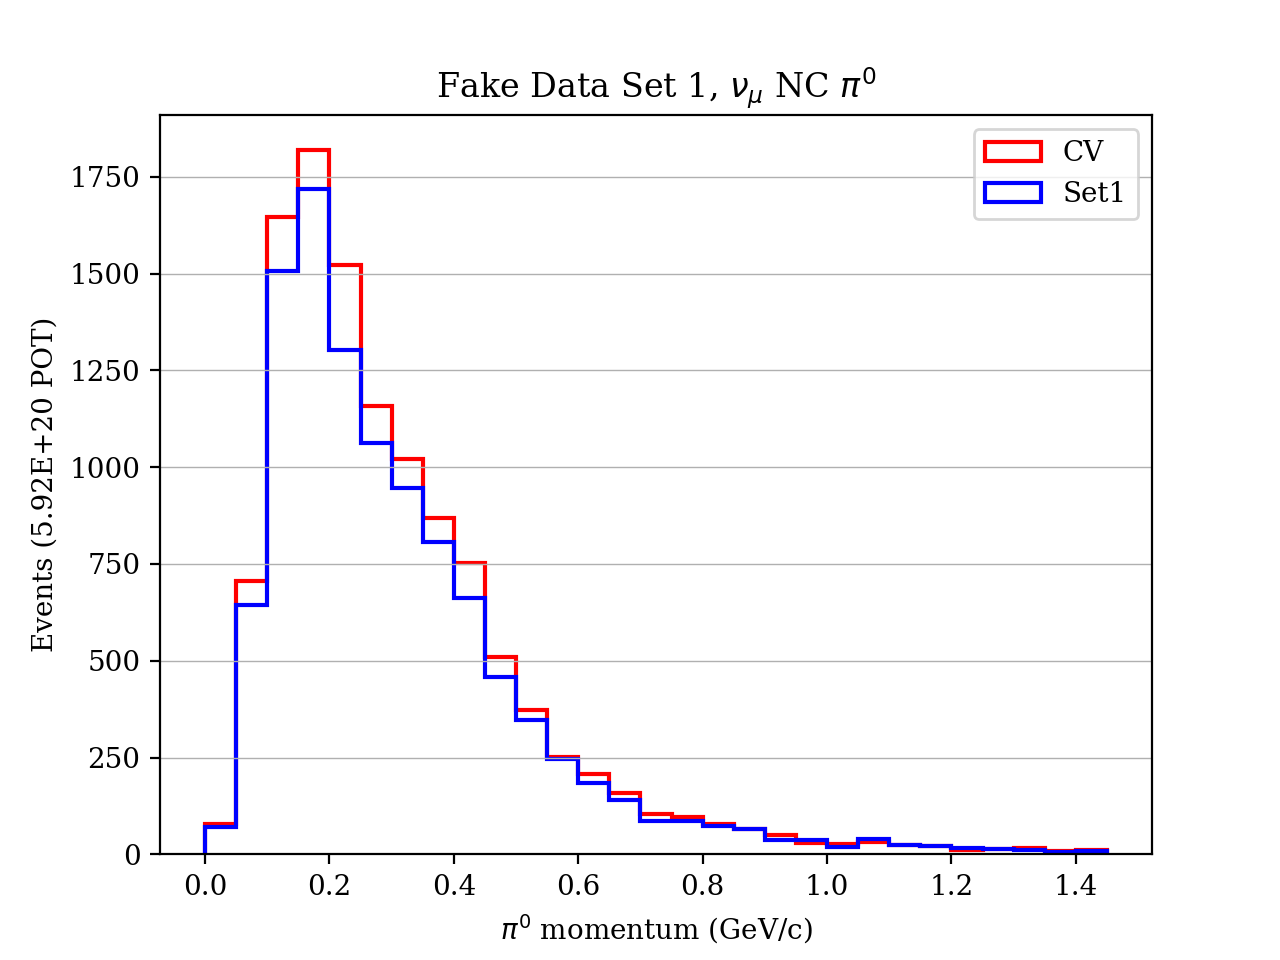

In [15]:
bins = np.arange(0.0,1.5,0.05)
var="p_pi0"
q=query_ncpi0
title="%s, $\\nu_\mu$ NC $\pi^0$"%(fd_title)
xlabel="$\pi^0$ momentum (GeV/c)"
ylabel="Events (%.2E POT)"%(total_pot_fd)

df_cv = ev_df_cv.query(q)
df_fd = ev_df_fd.query(q)

fig,ax = plt.subplots()

plt.grid(axis='y', linewidth=0.5)
plt.hist(df_cv[var], weights=df_cv["weight_pot"], color='red', label=cv_leg, bins=bins,**pltops_hist)
plt.hist(df_fd[var], color='blue', label=fd_leg, bins=bins,**pltops_hist)
plt.legend()
plt.title(title)
plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.show()
#plt.savefig("plots/genie_1mu1p_costheta.pdf")

<IPython.core.display.Javascript object>


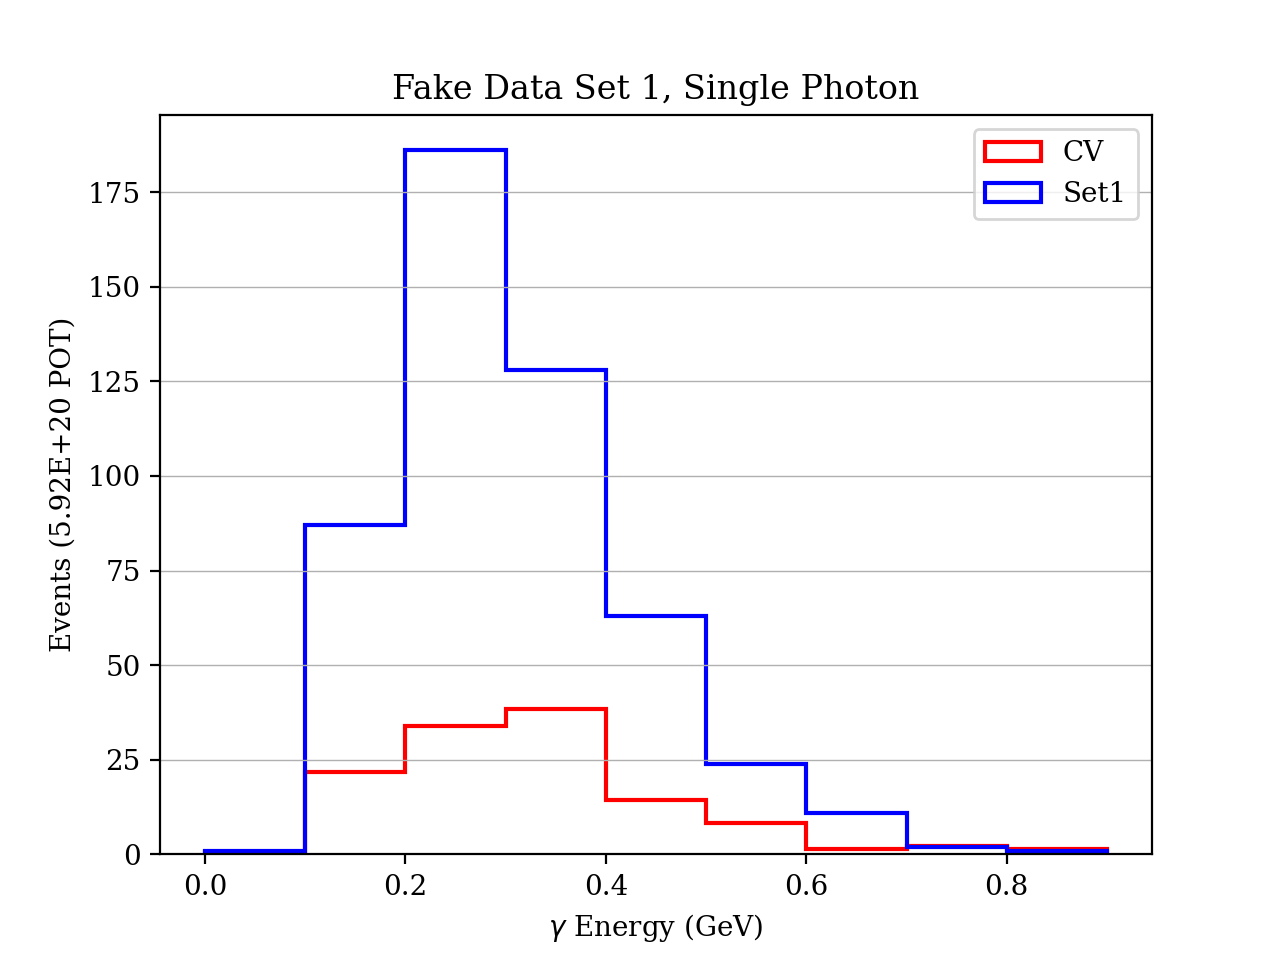

In [16]:
bins = np.arange(0.0,1.,0.1)
var="e_gamma"
q=query_1gXp
title="%s, Single Photon"%(fd_title)
xlabel="$\gamma$ Energy (GeV)"
ylabel="Events (%.2E POT)"%(total_pot_fd)

df_cv = ev_df_cv.query(q)
df_fd = ev_df_fd.query(q)

fig,ax = plt.subplots()

plt.grid(axis='y', linewidth=0.5)
plt.hist(df_cv[var], weights=df_cv["weight_pot"], color='red', label=cv_leg, bins=bins,**pltops_hist)
plt.hist(df_fd[var], color='blue', label=fd_leg, bins=bins,**pltops_hist)
plt.legend()
plt.title(title)
plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.show()
#plt.savefig("plots/genie_1mu1p_costheta.pdf")